In [2]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt # For Eigenface visualizations

# --- GLOBAL CONFIGURATIONS ---
# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal9"

# Define the scaling factor for upscaling images (for Dlib part)
scale_factor = 12

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Output directory for Eigenface related visualizations and data
eigenface_output_dir = os.path.join("processed_faces_newFinal9/eigenface_analysis_results")

# Ensure all output root directories exist
os.makedirs(root_output_dir, exist_ok=True)
os.makedirs(eigenface_output_dir, exist_ok=True) # Create this now


# --- Helper Function for Drawing Shapes ---
def draw_facial_shapes(image, landmarks):
    """
    Draws different geometric shapes on a given image based on facial landmarks.
    Args:
        image (numpy.ndarray): The image on which to draw.
        landmarks (dlib.full_object_detection): Dlib's landmark object.
    Returns:
        numpy.ndarray: The image with shapes drawn.
    """
    drawn_image = image.copy()

    color_eyebrows = (0, 255, 0)
    color_eyes = (255, 0, 0)
    color_nose_bridge = (0, 255, 255)
    color_nose_tip = (255, 255, 0)
    color_lips = (0, 165, 255)
    color_cheeks = (128, 0, 128)
    thickness = 2

    # Eyebrows (polylines)
    for i in range(17, 21):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)
    for i in range(22, 26):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # Eyes (Ellipses)
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    if len(left_eye_points) >= 5:
        try:
            (center_le, axes_le, angle_le) = cv2.fitEllipse(left_eye_points)
            if axes_le[0] > 0 and axes_le[1] > 0:
                cv2.ellipse(drawn_image, (int(center_le[0]), int(center_le[1])),
                            (int(axes_le[0] / 2), int(axes_le[1] / 2)),
                            angle_le, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])
    if len(right_eye_points) >= 5:
        try:
            (center_re, axes_re, angle_re) = cv2.fitEllipse(right_eye_points)
            if axes_re[0] > 0 and axes_re[1] > 0:
                cv2.ellipse(drawn_image, (int(center_re[0]), int(center_re[1])),
                            (int(axes_re[0] / 2), int(axes_re[1] / 2)),
                            angle_re, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    # Nose Bridge (Trapezium)
    nose_bridge_pts = np.array([
        (landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
        (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_bridge_pts], True, color_nose_bridge, thickness)

    # Nose Tip (Triangle)
    nose_tip_pts = np.array([
        (landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(31).x, landmarks.part(31).y),
        (landmarks.part(35).x, landmarks.part(35).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_tip_pts], True, color_nose_tip, thickness)

    # Lips (Outer Lip Ellipse)
    outer_lip_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)])
    if len(outer_lip_points) >= 5:
        try:
            (center_ol, axes_ol, angle_ol) = cv2.fitEllipse(outer_lip_points)
            if axes_ol[0] > 0 and axes_ol[1] > 0:
                cv2.ellipse(drawn_image, (int(center_ol[0]), int(center_ol[1])),
                            (int(axes_ol[0] / 2), int(axes_ol[1] / 2)),
                            angle_ol, 0, 360, color_lips, thickness)
        except cv2.error: pass

    # Cheeks (Broader Triangles)
    left_cheek_pts = np.array([
        (landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(2).x, landmarks.part(2).y),
        (landmarks.part(48).x, landmarks.part(48).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek_pts], True, color_cheeks, thickness)

    right_cheek_pts = np.array([
        (landmarks.part(45).x, landmarks.part(45).y), (landmarks.part(14).x, landmarks.part(14).y),
        (landmarks.part(54).x, landmarks.part(54).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [right_cheek_pts], True, color_cheeks, thickness)

    return drawn_image

# --- Helper Functions for Curve Fitting ---

def fit_parabola_params(points):
    if len(points) < 3: return np.nan, np.nan, np.nan
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    try:
        with np.errstate(all='raise'):
            coefficients = np.polyfit(x_coords, y_coords, 2)
            return tuple(coefficients)
    except Exception: return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    if len(points) < 5: return np.nan, np.nan, np.nan, np.nan, np.nan
    points_np = np.array(points, dtype=np.int32)
    try:
        (center, axes, angle) = cv2.fitEllipse(points_np)
        if axes[0] <= 0 or axes[1] <= 0: return np.nan, np.nan, np.nan, np.nan, np.nan
        return center[0], center[1], axes[0], axes[1], angle
    except cv2.error: return np.nan, np.nan, np.nan, np.nan, np.nan
    except Exception: return np.nan, np.nan, np.nan, np.nan, np.nan
    
    
    
    # --- Main Processing Loop for Dlib, Drawing, and Initial Feature Extraction ---
print("Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...")

all_facial_features_data = []

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)

    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")
    output_shapes_drawn_path = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    os.makedirs(output_shapes_drawn_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            # print(f"  Processing file: {filename}") # Uncomment for more verbose output

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                current_image_features = {'emotion': emotion, 'filename': filename}

                # Collect raw landmark data
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    current_image_features[f'landmark_{n}_x'] = x
                    current_image_features[f'landmark_{n}_y'] = y

                # Apply Curve Fitting Algorithms and Store Parameters
                leb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 22)]
                a_leb, b_leb, c_leb = fit_parabola_params(leb_points)
                current_image_features['leb_parabola_a'] = a_leb
                current_image_features['leb_parabola_b'] = b_leb
                current_image_features['leb_parabola_c'] = c_leb

                reb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(22, 27)]
                a_reb, b_reb, c_reb = fit_parabola_params(reb_points)
                current_image_features['reb_parabola_a'] = a_reb
                current_image_features['reb_parabola_b'] = b_reb
                current_image_features['reb_parabola_c'] = c_reb

                le_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                cx_le, cy_le, maj_le, min_le, ang_le = fit_ellipse_params(le_points)
                current_image_features['le_ellipse_center_x'] = cx_le; current_image_features['le_ellipse_center_y'] = cy_le
                current_image_features['le_ellipse_major_axis'] = maj_le; current_image_features['le_ellipse_minor_axis'] = min_le
                current_image_features['le_ellipse_angle'] = ang_le

                re_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                cx_re, cy_re, maj_re, min_re, ang_re = fit_ellipse_params(re_points)
                current_image_features['re_ellipse_center_x'] = cx_re; current_image_features['re_ellipse_center_y'] = cy_re
                current_image_features['re_ellipse_major_axis'] = maj_re; current_image_features['re_ellipse_minor_axis'] = min_re
                current_image_features['re_ellipse_angle'] = ang_re

                ol_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)]
                cx_ol, cy_ol, maj_ol, min_ol, ang_ol = fit_ellipse_params(ol_points)
                current_image_features['ol_ellipse_center_x'] = cx_ol; current_image_features['ol_ellipse_center_y'] = cy_ol
                current_image_features['ol_ellipse_major_axis'] = maj_ol; current_image_features['ol_ellipse_minor_axis'] = min_ol
                current_image_features['ol_ellipse_angle'] = ang_ol

                # Nose Bridge (Trapezium - extract vertices)
                current_image_features['nose_bridge_v1_x'] = landmarks.part(27).x; current_image_features['nose_bridge_v1_y'] = landmarks.part(27).y
                current_image_features['nose_bridge_v2_x'] = landmarks.part(28).x; current_image_features['nose_bridge_v2_y'] = landmarks.part(28).y
                current_image_features['nose_bridge_v3_x'] = landmarks.part(29).x; current_image_features['nose_bridge_v3_y'] = landmarks.part(29).y
                current_image_features['nose_bridge_v4_x'] = landmarks.part(30).x; current_image_features['nose_bridge_v4_y'] = landmarks.part(30).y

                # Nose Tip (Triangle - extract vertices)
                current_image_features['nose_tip_v1_x'] = landmarks.part(30).x; current_image_features['nose_tip_v1_y'] = landmarks.part(30).y
                current_image_features['nose_tip_v2_x'] = landmarks.part(31).x; current_image_features['nose_tip_v2_y'] = landmarks.part(31).y
                current_image_features['nose_tip_v3_x'] = landmarks.part(35).x; current_image_features['nose_tip_v3_y'] = landmarks.part(35).y

                # Left Cheek (Triangle - extract vertices)
                current_image_features['left_cheek_v1_x'] = landmarks.part(36).x; current_image_features['left_cheek_v1_y'] = landmarks.part(36).y
                current_image_features['left_cheek_v2_x'] = landmarks.part(2).x; current_image_features['left_cheek_v2_y'] = landmarks.part(2).y
                current_image_features['left_cheek_v3_x'] = landmarks.part(48).x; current_image_features['left_cheek_v3_y'] = landmarks.part(48).y

                # Right Cheek (Triangle - extract vertices)
                current_image_features['right_cheek_v1_x'] = landmarks.part(45).x; current_image_features['right_cheek_v1_y'] = landmarks.part(45).y
                current_image_features['right_cheek_v2_x'] = landmarks.part(14).x; current_image_features['right_cheek_v2_y'] = landmarks.part(14).y
                current_image_features['right_cheek_v3_x'] = landmarks.part(54).x; current_image_features['right_cheek_v3_y'] = landmarks.part(54).y

                all_facial_features_data.append(current_image_features)

                # Visualizations
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                drawn_image_shapes_only = np.zeros(upscaled_image.shape, dtype=np.uint8)

                # Draw quadrant lines
                nose_x = landmarks.part(30).x; nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                # Draw landmarks and labels
                drawn_index = 1; seen = set()
                for n in range(68):
                    x = landmarks.part(n).x; y = landmarks.part(n).y
                    if (x, y) in seen: continue
                    seen.add((x, y))
                    circle_radius = 2; fill_type = -1
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: offset_y = -10
                    elif n == 49: offset_x = -20; offset_y = 6
                    elif n == 50: offset_x = 0; offset_y = -8
                    elif n == 65: offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54: offset_y = -8
                    elif 55 <= n <= 59: offset_y = 10
                    elif 60 <= n <= 64: offset_y = -8
                    elif 65 <= n <= 67: offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, (0, 0, 255), fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1, cv2.LINE_AA)
                    drawn_index += 1

                drawn_image_shapes_only = draw_facial_shapes(drawn_image_shapes_only, landmarks)

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                output_image_path_shapes_drawn = os.path.join(output_shapes_drawn_path, filename)
                cv2.imwrite(output_image_path_shapes_drawn, drawn_image_shapes_only)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nStage 1: Dlib processing, shape drawing, and initial feature extraction complete!")

# Save all collected facial feature data to a single CSV file
if all_facial_features_data:
    df = pd.DataFrame(all_facial_features_data)
    df = df.reindex(columns=sorted(df.columns))
    csv_output_path = os.path.join(root_output_dir, "facial_features_and_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates and fitted shape parameters saved to: {csv_output_path}")
else:
    print("No facial feature data was collected in Stage 1.")
    
    
    # --- Configuration for Eigenface Decomposition ---
# Define the target size for all face images (Width, Height)
face_target_size = (100, 100)

# Number of top Eigenfaces to retain
num_eigenfaces_to_keep = 50

# --- Step 1: Data Preparation for Eigenfaces ---
print("\nStarting Stage 2: Eigenface Decomposition...")
print("Step 1: Collecting and preprocessing face images for PCA...")

all_face_vectors = []
image_metadata_pca = [] # Use a separate list for PCA metadata to avoid conflicts

for emotion in emotion_folders:
    # Read from the '_shapes_drawn' folder, as these are upscaled and have shapes,
    # but more importantly, they are already resized consistently by the previous step's upscaling.
    # For purest Eigenfaces, ideally these would be tight crops of the face only.
    emotion_dir = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")
    if not os.path.exists(emotion_dir):
        print(f"Warning: Directory '{emotion_dir}' not found. Skipping {emotion} for PCA.")
        continue

    for filename in os.listdir(emotion_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(emotion_dir, filename)
            img = cv2.imread(image_path)

            if img is None:
                print(f"Warning: Could not read image {image_path}. Skipping for PCA.")
                continue

            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to uniform size (ensure consistency, even if already done by upscaling in stage 1)
            # This is important as Dlib's upscaling is a factor, not a fixed size.
            resized_face = cv2.resize(gray_img, face_target_size, interpolation=cv2.INTER_AREA)

            # Flatten the 2D image into a 1D vector
            flattened_face = resized_face.flatten()

            all_face_vectors.append(flattened_face)
            image_metadata_pca.append({'emotion': emotion, 'filename': filename})

if not all_face_vectors:
    print("No face images found or processed for Eigenface decomposition. Exiting.")
    # You might want to exit the entire notebook or just skip this section
    # For a notebook, print and return might be more appropriate.
    # return
else: # Only proceed if there's data
    X = np.array(all_face_vectors, dtype=np.float64)
    num_images, num_pixels = X.shape
    print(f"Collected {num_images} images, each with {num_pixels} pixels for PCA.")

    # --- Step 2: Calculate the Mean Face ---
    print("Step 2: Calculating the mean face...")
    mean_face_vector = np.mean(X, axis=0)
    mean_face_image = mean_face_vector.reshape(face_target_size)

    plt.figure(figsize=(4, 4))
    plt.imshow(mean_face_image, cmap='gray')
    plt.title("Mean Face")
    plt.axis('off')
    mean_face_path = os.path.join(eigenface_output_dir, "mean_face.png")
    plt.savefig(mean_face_path)
    plt.close()
    print(f"Mean face saved to: {mean_face_path}")

    # --- Step 3: Subtract the Mean Face ---
    print("Step 3: Centering the data (subtracting mean face)...")
    X_centered = X - mean_face_vector

    # --- Step 4 & 5: Compute Eigenvalues and Eigenvectors ---
    print("Step 4 & 5: Computing eigenvectors and eigenvalues...")
    S_matrix = X_centered @ X_centered.T # N x N scatter matrix
    eigenvalues_small, eigenvectors_small = np.linalg.eigh(S_matrix)

    sorted_indices = np.argsort(eigenvalues_small)[::-1]
    eigenvalues_small = eigenvalues_small[sorted_indices]
    eigenvectors_small = eigenvectors_small[:, sorted_indices]

    eigenfaces_raw = X_centered.T @ eigenvectors_small
    eigenfaces = eigenfaces_raw / np.linalg.norm(eigenfaces_raw, axis=0) # Normalize

    print("Eigenvalues and eigenvectors computed.")

    # --- Step 6: Select Principal Components (Eigenfaces) ---
    print(f"Step 6: Selecting top {num_eigenfaces_to_keep} Eigenfaces...")
    selected_eigenfaces = eigenfaces[:, :num_eigenfaces_to_keep]
    selected_eigenvalues = eigenvalues_small[:num_eigenfaces_to_keep]

    print("Visualizing top Eigenfaces...")
    fig, axes = plt.subplots(1, min(num_eigenfaces_to_keep, 10), figsize=(20, 4))
    for i, ax in enumerate(axes):
        eigenface_img = selected_eigenfaces[:, i].reshape(face_target_size)
        ax.imshow(eigenface_img, cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
        ax.axis('off')
    plt.tight_layout()
    eigenfaces_plot_path = os.path.join(eigenface_output_dir, "top_eigenfaces.png")
    plt.savefig(eigenfaces_plot_path)
    plt.close()
    print(f"Top Eigenfaces visualization saved to: {eigenfaces_plot_path}")

    # --- Step 7: Project Faces onto Eigenface Space ---
    print("Step 7: Projecting original faces onto Eigenface space...")
    feature_vectors = X_centered @ selected_eigenfaces
    print(f"Projected {num_images} faces into a {num_eigenfaces_to_keep}-dimensional Eigenface space.")

    # --- Step 8: Store Eigenfaces and Feature Vectors ---
    print("Step 8: Storing feature vectors in CSV...")
    df_features = pd.DataFrame(feature_vectors)
    df_features.columns = [f'eigen_feature_{i}' for i in range(num_eigenfaces_to_keep)]
    df_metadata = pd.DataFrame(image_metadata_pca) # Use the correct metadata list for PCA
    final_df_pca = pd.concat([df_metadata, df_features], axis=1)

    features_csv_path_pca = os.path.join(eigenface_output_dir, "eigenface_features.csv")
    final_df_pca.to_csv(features_csv_path_pca, index=False)

    print(f"Eigenface feature vectors saved to: {features_csv_path_pca}")
    print("Stage 2: Eigenface decomposition complete!")

Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...

Processing emotion: anger...

Processing emotion: contempt...

Processing emotion: disgust...

Processing emotion: happy...

Processing emotion: sadness...

Processing emotion: fear...

Processing emotion: surprise...
  No face detected in S051_002_00000017.png from surprise folder.

Stage 1: Dlib processing, shape drawing, and initial feature extraction complete!
All facial landmark coordinates and fitted shape parameters saved to: processed_faces_newFinal9\facial_features_and_landmarks_data.csv

Starting Stage 2: Eigenface Decomposition...
Step 1: Collecting and preprocessing face images for PCA...
Collected 980 images, each with 10000 pixels for PCA.
Step 2: Calculating the mean face...
Mean face saved to: processed_faces_newFinal9/eigenface_analysis_results\mean_face.png
Step 3: Centering the data (subtracting mean face)...
Step 4 & 5: Computing eigenvectors and eigenvalues...
Eigenvalues and ei

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load CSV file ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train KNN classifier ---
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

# --- 8. Evaluate model ---
y_pred = knn_model.predict(X_test_scaled)

# print("✅ Training Accuracy (KNN):", round(knn_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (KNN):", round(knn_model.score(X_test_scaled, y_test), 2))

train_accuracy_knn = knn_model.score(X_train_scaled, y_train)
test_accuracy_knn = knn_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (KNN): {train_accuracy_knn * 100:.2f}%")
print(f"✅ Testing Accuracy  (KNN): {test_accuracy_knn * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (KNN): 93.24%
✅ Testing Accuracy  (KNN): 72.45%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.61      0.41      0.49        27
    contempt       0.50      0.45      0.48        11
     disgust       0.56      0.80      0.66        35
        fear       1.00      0.47      0.64        15
       happy       0.89      0.80      0.85        41
     sadness       0.60      0.53      0.56        17
    surprise       0.83      0.98      0.90        50

    accuracy                           0.72       196
   macro avg       0.71      0.63      0.65       196
weighted avg       0.74      0.72      0.72       196


✅ Confusion Matrix:
 [[11  1 11  0  0  1  3]
 [ 1  5  0  0  0  3  2]
 [ 3  0 28  0  3  1  0]
 [ 0  1  3  7  1  0  3]
 [ 0  0  7  0 33  1  0]
 [ 2  3  1  0  0  9  2]
 [ 1  0  0  0  0  0 49]]


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load CSV file ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train SVC classifier (default RBF kernel) ---
svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)

# --- 8. Evaluate model ---
y_pred = svc_model.predict(X_test_scaled)

# print("✅ Training Accuracy (SVC):", round(svc_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (SVC):", round(svc_model.score(X_test_scaled, y_test), 2))

train_accuracy_svc = svc_model.score(X_train_scaled, y_train)
test_accuracy_svc = svc_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (SVC): {train_accuracy_svc * 100:.2f}%")
print(f"✅ Testing Accuracy  (SVC): {test_accuracy_svc * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (SVC): 99.36%
✅ Testing Accuracy  (SVC): 88.78%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.67      0.78        27
    contempt       0.77      0.91      0.83        11
     disgust       0.78      0.89      0.83        35
        fear       0.92      0.73      0.81        15
       happy       0.87      1.00      0.93        41
     sadness       0.93      0.76      0.84        17
    surprise       0.98      1.00      0.99        50

    accuracy                           0.89       196
   macro avg       0.88      0.85      0.86       196
weighted avg       0.90      0.89      0.88       196


✅ Confusion Matrix:
 [[18  0  8  0  0  0  1]
 [ 0 10  0  0  0  1  0]
 [ 0  0 31  1  3  0  0]
 [ 0  1  1 11  2  0  0]
 [ 0  0  0  0 41  0  0]
 [ 1  2  0  0  1 13  0]
 [ 0  0  0  0  0  0 50]]


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load data ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Prepare features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Split into train/test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define parameter grid for GridSearchCV ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

# --- 8. Grid Search with 5-fold cross-validation ---
grid = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

# --- 9. Best parameters ---
print("✅ Best Parameters:", grid.best_params_)

# --- 10. Evaluate best model ---
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Tuned SVC):", round(best_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Tuned SVC):", round(best_model.score(X_test_scaled, y_test), 2))

train_accuracy_tuned_svc = best_model.score(X_train_scaled, y_train)
test_accuracy_tuned_svc = best_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Tuned SVC): {train_accuracy_tuned_svc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVC): {test_accuracy_tuned_svc * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
✅ Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
✅ Training Accuracy (Tuned SVC): 100.00%
✅ Testing Accuracy  (Tuned SVC): 91.84%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.95      0.78      0.86        27
    contempt       0.73      1.00      0.85        11
     disgust       0.89      0.89      0.89        35
        fear       1.00      0.87      0.93        15
       happy       0.89      1.00      0.94        41
     sadness       0.93      0.82      0.88        17
    surprise       0.98      0.98      0.98        50

    accuracy                           0.92       196
   macro avg       0.91      0.90      0.90       196
weighted avg       0.92      0.92      0.92       196


✅ Confusion Matrix:
 [[21  0  4  0  0  1  1]
 [ 0 11  0  0  0  0  0]
 [ 0  0 31  0  4  0  0]
 [ 0  1  0 13  1  0  0]
 [ 0  0  0  0 41  0  0]
 [ 1  2  0  0  0 14  0]
 [ 0  1

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the CSV file ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric/non-feature columns ---
df = df.drop(columns=['filename'])

# --- 3. Split into features (X) and target (y) ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels to numeric form ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Split into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Initialize and train Random Forest model ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = rf_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Random Forest):", round(rf_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Random Forest):", round(rf_model.score(X_test_scaled, y_test), 2))


train_accuracy_rf = rf_model.score(X_train_scaled, y_train)
test_accuracy_rf = rf_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Random Forest): {train_accuracy_rf * 100:.2f}%")
print(f"✅ Testing Accuracy  (Random Forest): {test_accuracy_rf * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Random Forest): 100.00%
✅ Testing Accuracy  (Random Forest): 83.67%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.81      0.63      0.71        27
    contempt       0.90      0.82      0.86        11
     disgust       0.71      0.83      0.76        35
        fear       1.00      0.47      0.64        15
       happy       0.82      1.00      0.90        41
     sadness       1.00      0.65      0.79        17
    surprise       0.89      1.00      0.94        50

    accuracy                           0.84       196
   macro avg       0.88      0.77      0.80       196
weighted avg       0.85      0.84      0.83       196


✅ Confusion Matrix:
 [[17  0  9  0  0  0  1]
 [ 1  9  0  0  0  0  1]
 [ 2  0 29  0  4  0  0]
 [ 0  1  1  7  3  0  3]
 [ 0  0  0  0 41  0  0]
 [ 1  0  2  0  2 11  1]
 [ 0  0  0  0  0  0 50]]


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load CSV ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-feature columns ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode target labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Standardize features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Initialize and train Logistic Regression model ---
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
logreg_model.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = logreg_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Logistic Regression):", round(logreg_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Logistic Regression):", round(logreg_model.score(X_test_scaled, y_test), 2))


train_accuracy_logreg = logreg_model.score(X_train_scaled, y_train)
test_accuracy_logreg = logreg_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Logistic Regression): {train_accuracy_logreg * 100:.2f}%")
print(f"✅ Testing Accuracy  (Logistic Regression): {test_accuracy_logreg * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Logistic Regression): 92.73%
✅ Testing Accuracy  (Logistic Regression): 78.06%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.65      0.48      0.55        27
    contempt       0.89      0.73      0.80        11
     disgust       0.65      0.69      0.67        35
        fear       0.80      0.53      0.64        15
       happy       0.89      0.98      0.93        41
     sadness       0.73      0.65      0.69        17
    surprise       0.82      0.98      0.89        50

    accuracy                           0.78       196
   macro avg       0.78      0.72      0.74       196
weighted avg       0.77      0.78      0.77       196


✅ Confusion Matrix:
 [[13  0 10  0  1  0  3]
 [ 1  8  0  0  0  2  0]
 [ 3  0 24  0  2  1  5]
 [ 1  0  1  8  2  1  2]
 [ 0  0  0  1 40  0  0]
 [ 2  1  2  0  0 11  1]
 [ 0  0  0  1  0  0 49]]


c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load dataset ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop unnecessary columns ---
df = df.drop(columns=['filename'])  # Drop filename column

# --- 3. Separate features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Initialize and train MLP ---
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = mlp_model.predict(X_test_scaled)

# print("✅ Training Accuracy (MLP):", round(mlp_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (MLP):", round(mlp_model.score(X_test_scaled, y_test), 2))


train_accuracy_mlp = mlp_model.score(X_train_scaled, y_train)
test_accuracy_mlp = mlp_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (MLP): {train_accuracy_mlp * 100:.2f}%")
print(f"✅ Testing Accuracy  (MLP): {test_accuracy_mlp * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (MLP): 100.00%
✅ Testing Accuracy  (MLP): 85.20%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.94      0.63      0.76        27
    contempt       0.91      0.91      0.91        11
     disgust       0.78      0.80      0.79        35
        fear       0.83      0.67      0.74        15
       happy       0.91      0.98      0.94        41
     sadness       0.72      0.76      0.74        17
    surprise       0.86      0.98      0.92        50

    accuracy                           0.85       196
   macro avg       0.85      0.82      0.83       196
weighted avg       0.86      0.85      0.85       196


✅ Confusion Matrix:
 [[17  0  7  0  1  1  1]
 [ 0 10  0  0  0  1  0]
 [ 0  0 28  1  1  1  4]
 [ 0  0  0 10  2  2  1]
 [ 0  0  0  1 40  0  0]
 [ 1  0  1  0  0 13  2]
 [ 0  1  0  0  0  0 49]]


Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 1.8632 - accuracy: 0.2500 - val_loss: 1.6946 - val_accuracy: 0.3929
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.4481 - accuracy: 0.5357 - val_loss: 1.4313 - val_accuracy: 0.5510
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1750 - accuracy: 0.6594 - val_loss: 1.2253 - val_accuracy: 0.6276
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.9666 - accuracy: 0.7398 - val_loss: 1.0725 - val_accuracy: 0.6888
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.8110 - accuracy: 0.7985 - val_loss: 0.9517 - val_accuracy: 0.7296
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6907 - accuracy: 0.8418 - val_loss: 0.8614 - val_accuracy: 0.7449
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.8622 - val_loss: 0.7902 - val_accuracy: 0.7500
Epoch 8/50
25/25 [==

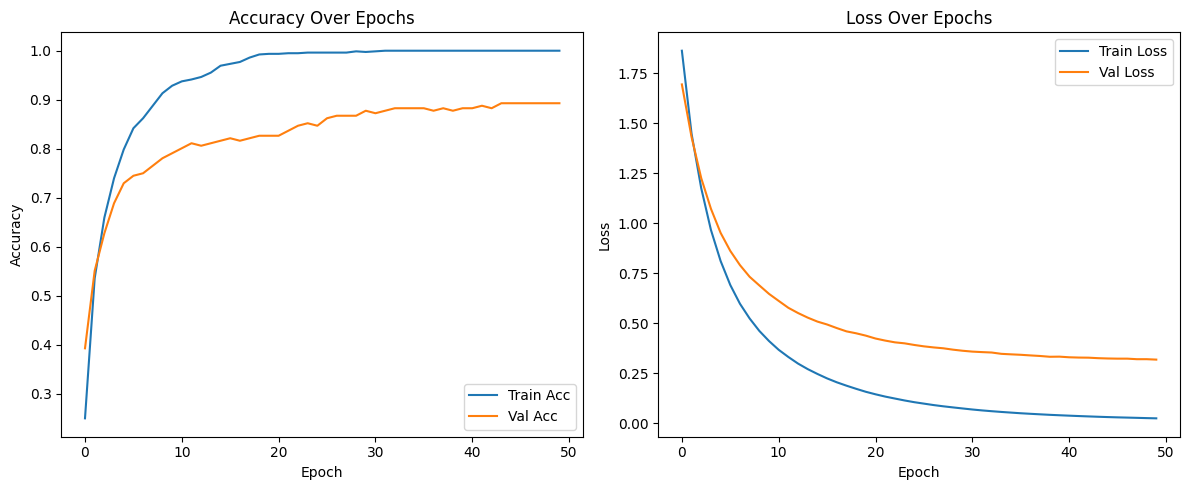

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- 1. Load dataset ---
file_path = 'processed_faces_newFinal9/eigenface_analysis_results/eigenface_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop unnecessary columns ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define and compile the Keras MLP model ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Train the model and store history ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- 9. Evaluate model performance ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Keras MLP): {test_acc * 100:.2f}%")

# --- 10. Classification report & confusion matrix ---
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(X_test_scaled), axis=1)

print("\n✅ Classification Report:\n", classification_report(
    y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

# --- 11. Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt # For Eigenface visualizations

# --- GLOBAL CONFIGURATIONS ---
# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(
    "models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat"
)

# Define the root directories for input and output
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal9"

# Define the scaling factor for upscaling images (for Dlib part)
scale_factor = 12

# List of emotion folders
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

# Output directory for Eigenface related visualizations and data
eigenface_output_dir = os.path.join("processed_faces_newFinal9/eigenface_analysis_results")

# Ensure all output root directories exist
os.makedirs(root_output_dir, exist_ok=True)
os.makedirs(eigenface_output_dir, exist_ok=True) # Create this now


# --- Helper Function for Drawing Shapes ---
def draw_facial_shapes(image, landmarks):
    """
    Draws different geometric shapes on a given image based on facial landmarks.
    Args:
        image (numpy.ndarray): The image on which to draw.
        landmarks (dlib.full_object_detection): Dlib's landmark object.
    Returns:
        numpy.ndarray: The image with shapes drawn.
    """
    drawn_image = image.copy()

    color_eyebrows = (0, 255, 0)
    color_eyes = (255, 0, 0)
    color_nose_bridge = (0, 255, 255)
    color_nose_tip = (255, 255, 0)
    color_lips = (0, 165, 255)
    color_cheeks = (128, 0, 128)
    thickness = 2

    # Eyebrows (polylines)
    for i in range(17, 21):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)
    for i in range(22, 26):
        pt1 = (landmarks.part(i).x, landmarks.part(i).y)
        pt2 = (landmarks.part(i + 1).x, landmarks.part(i + 1).y)
        cv2.line(drawn_image, pt1, pt2, color_eyebrows, thickness)

    # Eyes (Ellipses)
    left_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)])
    if len(left_eye_points) >= 5:
        try:
            (center_le, axes_le, angle_le) = cv2.fitEllipse(left_eye_points)
            if axes_le[0] > 0 and axes_le[1] > 0:
                cv2.ellipse(drawn_image, (int(center_le[0]), int(center_le[1])),
                            (int(axes_le[0] / 2), int(axes_le[1] / 2)),
                            angle_le, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    right_eye_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)])
    if len(right_eye_points) >= 5:
        try:
            (center_re, axes_re, angle_re) = cv2.fitEllipse(right_eye_points)
            if axes_re[0] > 0 and axes_re[1] > 0:
                cv2.ellipse(drawn_image, (int(center_re[0]), int(center_re[1])),
                            (int(axes_re[0] / 2), int(axes_re[1] / 2)),
                            angle_re, 0, 360, color_eyes, thickness)
        except cv2.error: pass

    # Nose Bridge (Trapezium)
    nose_bridge_pts = np.array([
        (landmarks.part(27).x, landmarks.part(27).y), (landmarks.part(28).x, landmarks.part(28).y),
        (landmarks.part(29).x, landmarks.part(29).y), (landmarks.part(30).x, landmarks.part(30).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_bridge_pts], True, color_nose_bridge, thickness)

    # Nose Tip (Triangle)
    nose_tip_pts = np.array([
        (landmarks.part(30).x, landmarks.part(30).y), (landmarks.part(31).x, landmarks.part(31).y),
        (landmarks.part(35).x, landmarks.part(35).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [nose_tip_pts], True, color_nose_tip, thickness)

    # Lips (Outer Lip Ellipse)
    outer_lip_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)])
    if len(outer_lip_points) >= 5:
        try:
            (center_ol, axes_ol, angle_ol) = cv2.fitEllipse(outer_lip_points)
            if axes_ol[0] > 0 and axes_ol[1] > 0:
                cv2.ellipse(drawn_image, (int(center_ol[0]), int(center_ol[1])),
                            (int(axes_ol[0] / 2), int(axes_ol[1] / 2)),
                            angle_ol, 0, 360, color_lips, thickness)
        except cv2.error: pass

    # Cheeks (Broader Triangles)
    left_cheek_pts = np.array([
        (landmarks.part(36).x, landmarks.part(36).y), (landmarks.part(2).x, landmarks.part(2).y),
        (landmarks.part(48).x, landmarks.part(48).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [left_cheek_pts], True, color_cheeks, thickness)

    right_cheek_pts = np.array([
        (landmarks.part(45).x, landmarks.part(45).y), (landmarks.part(14).x, landmarks.part(14).y),
        (landmarks.part(54).x, landmarks.part(54).y)
    ], np.int32).reshape((-1, 1, 2))
    cv2.polylines(drawn_image, [right_cheek_pts], True, color_cheeks, thickness)

    return drawn_image

# --- Helper Functions for Curve Fitting ---

def fit_parabola_params(points):
    if len(points) < 3: return np.nan, np.nan, np.nan
    x_coords = np.array([p[0] for p in points])
    y_coords = np.array([p[1] for p in points])
    try:
        with np.errstate(all='raise'):
            coefficients = np.polyfit(x_coords, y_coords, 2)
            return tuple(coefficients)
    except Exception: return np.nan, np.nan, np.nan

def fit_ellipse_params(points):
    if len(points) < 5: return np.nan, np.nan, np.nan, np.nan, np.nan
    points_np = np.array(points, dtype=np.int32)
    try:
        (center, axes, angle) = cv2.fitEllipse(points_np)
        if axes[0] <= 0 or axes[1] <= 0: return np.nan, np.nan, np.nan, np.nan, np.nan
        return center[0], center[1], axes[0], axes[1], angle
    except cv2.error: return np.nan, np.nan, np.nan, np.nan, np.nan
    except Exception: return np.nan, np.nan, np.nan, np.nan, np.nan
    
    
    
    # --- Main Processing Loop for Dlib, Drawing, and Initial Feature Extraction ---
print("Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...")

all_facial_features_data = []

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)

    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")
    output_shapes_drawn_path = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    os.makedirs(output_shapes_drawn_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue

            # print(f"  Processing file: {filename}") # Uncomment for more verbose output

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                current_image_features = {'emotion': emotion, 'filename': filename}

                # Collect raw landmark data
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    current_image_features[f'landmark_{n}_x'] = x
                    current_image_features[f'landmark_{n}_y'] = y

                # Apply Curve Fitting Algorithms and Store Parameters
                leb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(17, 22)]
                a_leb, b_leb, c_leb = fit_parabola_params(leb_points)
                current_image_features['leb_parabola_a'] = a_leb
                current_image_features['leb_parabola_b'] = b_leb
                current_image_features['leb_parabola_c'] = c_leb

                reb_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(22, 27)]
                a_reb, b_reb, c_reb = fit_parabola_params(reb_points)
                current_image_features['reb_parabola_a'] = a_reb
                current_image_features['reb_parabola_b'] = b_reb
                current_image_features['reb_parabola_c'] = c_reb

                le_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(36, 42)]
                cx_le, cy_le, maj_le, min_le, ang_le = fit_ellipse_params(le_points)
                current_image_features['le_ellipse_center_x'] = cx_le; current_image_features['le_ellipse_center_y'] = cy_le
                current_image_features['le_ellipse_major_axis'] = maj_le; current_image_features['le_ellipse_minor_axis'] = min_le
                current_image_features['le_ellipse_angle'] = ang_le

                re_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(42, 48)]
                cx_re, cy_re, maj_re, min_re, ang_re = fit_ellipse_params(re_points)
                current_image_features['re_ellipse_center_x'] = cx_re; current_image_features['re_ellipse_center_y'] = cy_re
                current_image_features['re_ellipse_major_axis'] = maj_re; current_image_features['re_ellipse_minor_axis'] = min_re
                current_image_features['re_ellipse_angle'] = ang_re

                ol_points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 60)]
                cx_ol, cy_ol, maj_ol, min_ol, ang_ol = fit_ellipse_params(ol_points)
                current_image_features['ol_ellipse_center_x'] = cx_ol; current_image_features['ol_ellipse_center_y'] = cy_ol
                current_image_features['ol_ellipse_major_axis'] = maj_ol; current_image_features['ol_ellipse_minor_axis'] = min_ol
                current_image_features['ol_ellipse_angle'] = ang_ol

                # Nose Bridge (Trapezium - extract vertices)
                current_image_features['nose_bridge_v1_x'] = landmarks.part(27).x; current_image_features['nose_bridge_v1_y'] = landmarks.part(27).y
                current_image_features['nose_bridge_v2_x'] = landmarks.part(28).x; current_image_features['nose_bridge_v2_y'] = landmarks.part(28).y
                current_image_features['nose_bridge_v3_x'] = landmarks.part(29).x; current_image_features['nose_bridge_v3_y'] = landmarks.part(29).y
                current_image_features['nose_bridge_v4_x'] = landmarks.part(30).x; current_image_features['nose_bridge_v4_y'] = landmarks.part(30).y

                # Nose Tip (Triangle - extract vertices)
                current_image_features['nose_tip_v1_x'] = landmarks.part(30).x; current_image_features['nose_tip_v1_y'] = landmarks.part(30).y
                current_image_features['nose_tip_v2_x'] = landmarks.part(31).x; current_image_features['nose_tip_v2_y'] = landmarks.part(31).y
                current_image_features['nose_tip_v3_x'] = landmarks.part(35).x; current_image_features['nose_tip_v3_y'] = landmarks.part(35).y

                # Left Cheek (Triangle - extract vertices)
                current_image_features['left_cheek_v1_x'] = landmarks.part(36).x; current_image_features['left_cheek_v1_y'] = landmarks.part(36).y
                current_image_features['left_cheek_v2_x'] = landmarks.part(2).x; current_image_features['left_cheek_v2_y'] = landmarks.part(2).y
                current_image_features['left_cheek_v3_x'] = landmarks.part(48).x; current_image_features['left_cheek_v3_y'] = landmarks.part(48).y

                # Right Cheek (Triangle - extract vertices)
                current_image_features['right_cheek_v1_x'] = landmarks.part(45).x; current_image_features['right_cheek_v1_y'] = landmarks.part(45).y
                current_image_features['right_cheek_v2_x'] = landmarks.part(14).x; current_image_features['right_cheek_v2_y'] = landmarks.part(14).y
                current_image_features['right_cheek_v3_x'] = landmarks.part(54).x; current_image_features['right_cheek_v3_y'] = landmarks.part(54).y

                all_facial_features_data.append(current_image_features)

                # Visualizations
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                drawn_image_shapes_only = np.zeros(upscaled_image.shape, dtype=np.uint8)

                # Draw quadrant lines
                nose_x = landmarks.part(30).x; nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                # Draw landmarks and labels
                drawn_index = 1; seen = set()
                for n in range(68):
                    x = landmarks.part(n).x; y = landmarks.part(n).y
                    if (x, y) in seen: continue
                    seen.add((x, y))
                    circle_radius = 2; fill_type = -1
                    offset_x, offset_y = -6, 10
                    if n in [37, 38, 39, 43, 44, 45]: offset_y = -10
                    elif n == 49: offset_x = -20; offset_y = 6
                    elif n == 50: offset_x = 0; offset_y = -8
                    elif n == 65: offset_x = -14; offset_y = 10
                    elif 48 <= n <= 54: offset_y = -8
                    elif 55 <= n <= 59: offset_y = 10
                    elif 60 <= n <= 64: offset_y = -8
                    elif 65 <= n <= 67: offset_y = 10

                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, (0, 0, 255), fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.35, (255, 255, 255), 1, cv2.LINE_AA)
                    drawn_index += 1

                drawn_image_shapes_only = draw_facial_shapes(drawn_image_shapes_only, landmarks)

                output_image_path_with_photo = os.path.join(output_with_photo_path, filename)
                cv2.imwrite(output_image_path_with_photo, drawn_image_with_photo)
                output_image_path_without_photo = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(output_image_path_without_photo, drawn_image_without_photo)
                output_image_path_shapes_drawn = os.path.join(output_shapes_drawn_path, filename)
                cv2.imwrite(output_image_path_shapes_drawn, drawn_image_shapes_only)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nStage 1: Dlib processing, shape drawing, and initial feature extraction complete!")

# Save all collected facial feature data to a single CSV file
if all_facial_features_data:
    df = pd.DataFrame(all_facial_features_data)
    df = df.reindex(columns=sorted(df.columns))
    csv_output_path = os.path.join(root_output_dir, "facial_features_and_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates and fitted shape parameters saved to: {csv_output_path}")
else:
    print("No facial feature data was collected in Stage 1.")
    
    
    # --- Configuration for Eigenface Decomposition ---
# Define the target size for all face images (Width, Height)
face_target_size = (100, 100)

# Number of top Eigenfaces to retain
num_eigenfaces_to_keep = 50

# --- Step 1: Data Preparation for Eigenfaces ---
print("\nStarting Stage 2: Eigenface Decomposition...")
print("Step 1: Collecting and preprocessing face images for PCA...")

all_face_vectors = []
image_metadata_pca = [] # Use a separate list for PCA metadata to avoid conflicts

for emotion in emotion_folders:
    # Read from the '_shapes_drawn' folder, as these are upscaled and have shapes,
    # but more importantly, they are already resized consistently by the previous step's upscaling.
    # For purest Eigenfaces, ideally these would be tight crops of the face only.
    emotion_dir = os.path.join(root_output_dir, emotion, f"{emotion}_shapes_drawn")
    if not os.path.exists(emotion_dir):
        print(f"Warning: Directory '{emotion_dir}' not found. Skipping {emotion} for PCA.")
        continue

    for filename in os.listdir(emotion_dir):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(emotion_dir, filename)
            img = cv2.imread(image_path)

            if img is None:
                print(f"Warning: Could not read image {image_path}. Skipping for PCA.")
                continue

            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Resize to uniform size (ensure consistency, even if already done by upscaling in stage 1)
            # This is important as Dlib's upscaling is a factor, not a fixed size.
            resized_face = cv2.resize(gray_img, face_target_size, interpolation=cv2.INTER_AREA)

            # Flatten the 2D image into a 1D vector
            flattened_face = resized_face.flatten()

            all_face_vectors.append(flattened_face)
            image_metadata_pca.append({'emotion': emotion, 'filename': filename})

if not all_face_vectors:
    print("No face images found or processed for Eigenface decomposition. Exiting.")
    # You might want to exit the entire notebook or just skip this section
    # For a notebook, print and return might be more appropriate.
    # return
else: # Only proceed if there's data
    X = np.array(all_face_vectors, dtype=np.float64)
    num_images, num_pixels = X.shape
    print(f"Collected {num_images} images, each with {num_pixels} pixels for PCA.")

    # --- Step 2: Calculate the Mean Face ---
    print("Step 2: Calculating the mean face...")
    mean_face_vector = np.mean(X, axis=0)
    mean_face_image = mean_face_vector.reshape(face_target_size)

    plt.figure(figsize=(4, 4))
    plt.imshow(mean_face_image, cmap='gray')
    plt.title("Mean Face")
    plt.axis('off')
    mean_face_path = os.path.join(eigenface_output_dir, "mean_face.png")
    plt.savefig(mean_face_path)
    plt.close()
    print(f"Mean face saved to: {mean_face_path}")

    # --- Step 3: Subtract the Mean Face ---
    print("Step 3: Centering the data (subtracting mean face)...")
    X_centered = X - mean_face_vector

    # --- Step 4 & 5: Compute Eigenvalues and Eigenvectors ---
    print("Step 4 & 5: Computing eigenvectors and eigenvalues...")
    S_matrix = X_centered @ X_centered.T # N x N scatter matrix
    eigenvalues_small, eigenvectors_small = np.linalg.eigh(S_matrix)

    sorted_indices = np.argsort(eigenvalues_small)[::-1]
    eigenvalues_small = eigenvalues_small[sorted_indices]
    eigenvectors_small = eigenvectors_small[:, sorted_indices]

    eigenfaces_raw = X_centered.T @ eigenvectors_small
    eigenfaces = eigenfaces_raw / np.linalg.norm(eigenfaces_raw, axis=0) # Normalize

    print("Eigenvalues and eigenvectors computed.")

    # --- Step 6: Select Principal Components (Eigenfaces) ---
    print(f"Step 6: Selecting top {num_eigenfaces_to_keep} Eigenfaces...")
    selected_eigenfaces = eigenfaces[:, :num_eigenfaces_to_keep]
    selected_eigenvalues = eigenvalues_small[:num_eigenfaces_to_keep]

    print("Visualizing top Eigenfaces...")
    fig, axes = plt.subplots(1, min(num_eigenfaces_to_keep, 10), figsize=(20, 4))
    for i, ax in enumerate(axes):
        eigenface_img = selected_eigenfaces[:, i].reshape(face_target_size)
        ax.imshow(eigenface_img, cmap='gray')
        ax.set_title(f'Eigenface {i+1}')
        ax.axis('off')
    plt.tight_layout()
    eigenfaces_plot_path = os.path.join(eigenface_output_dir, "top_eigenfaces.png")
    plt.savefig(eigenfaces_plot_path)
    plt.close()
    print(f"Top Eigenfaces visualization saved to: {eigenfaces_plot_path}")

    # --- Step 7: Project Faces onto Eigenface Space ---
    print("Step 7: Projecting original faces onto Eigenface space...")
    feature_vectors = X_centered @ selected_eigenfaces
    print(f"Projected {num_images} faces into a {num_eigenfaces_to_keep}-dimensional Eigenface space.")

    # --- Step 8: Store Eigenfaces and Feature Vectors ---
    print("Step 8: Storing feature vectors in CSV...")
    df_features = pd.DataFrame(feature_vectors)
    df_features.columns = [f'eigen_feature_{i}' for i in range(num_eigenfaces_to_keep)]
    df_metadata = pd.DataFrame(image_metadata_pca) # Use the correct metadata list for PCA
    final_df_pca = pd.concat([df_metadata, df_features], axis=1)

    features_csv_path_pca = os.path.join(eigenface_output_dir, "eigenface_features.csv")
    final_df_pca.to_csv(features_csv_path_pca, index=False)

    print(f"Eigenface feature vectors saved to: {features_csv_path_pca}")
    print("Stage 2: Eigenface decomposition complete!")
    
    
    
# --- Configuration for Linear Discriminant Analysis (LDA) ---
# Input CSV from Eigenface decomposition
eigenface_features_csv_path = os.path.join(eigenface_output_dir, "eigenface_features.csv")

# Output CSV for LDA features
lda_output_dir = os.path.join("processed_faces_newFinal9/lda_analysis_results") # New directory for LDA outputs
os.makedirs(lda_output_dir, exist_ok=True)
lda_features_csv_path = os.path.join(lda_output_dir, "lda_features.csv")

# --- Step 1: Load PCA Feature Vectors and Labels ---
print("\nStarting Stage 3: Linear Discriminant Analysis (LDA)...")
print("Step 1: Loading Eigenface features and labels...")

try:
    df_eigen_features = pd.read_csv(eigenface_features_csv_path)
except FileNotFoundError:
    print(f"Error: Eigenface features CSV not found at {eigenface_features_csv_path}. Please run Eigenface decomposition first.")
    # Exit or return if the file is not found
    # For a notebook, you might just print and stop this cell execution
    # For a script, exit()
    exit() # Or use a more graceful handling for notebook if you prefer

# Separate features (X) and labels (y)
# Feature columns are typically named 'eigen_feature_0', 'eigen_feature_1', etc.
# We need to dynamically identify them.
feature_cols = [col for col in df_eigen_features.columns if col.startswith('eigen_feature_')]
X_pca = df_eigen_features[feature_cols].values # NumPy array of PCA features
y_labels = df_eigen_features['emotion'].values # NumPy array of emotion labels
filenames_pca = df_eigen_features['filename'].values # Keep filenames for final CSV

print(f"Loaded {X_pca.shape[0]} samples with {X_pca.shape[1]} PCA features.")

# Map emotion strings to numerical labels for easier processing
unique_emotions = np.unique(y_labels)
emotion_to_int = {emotion: i for i, emotion in enumerate(unique_emotions)}
y_numeric = np.array([emotion_to_int[e] for e in y_labels])

num_classes = len(unique_emotions)
print(f"Detected {num_classes} emotion classes: {unique_emotions}")

# --- Step 2: Calculate Class Means and Total Mean ---
print("Step 2: Calculating class means and total mean...")

overall_mean = np.mean(X_pca, axis=0) # Total mean of all PCA features

# Calculate mean for each class
class_means = {}
for i, emotion_name in enumerate(unique_emotions):
    class_indices = np.where(y_labels == emotion_name)[0]
    class_samples = X_pca[class_indices]
    class_means[i] = np.mean(class_samples, axis=0)

print("Class means and overall mean calculated.")

# --- Step 3: Calculate Within-Class Scatter Matrix (Sw) ---
print("Step 3: Calculating Within-Class Scatter Matrix (Sw)...")
# Initialize Sw as a zero matrix of size (num_pca_features x num_pca_features)
Sw = np.zeros((X_pca.shape[1], X_pca.shape[1]))

for i, emotion_name in enumerate(unique_emotions):
    class_indices = np.where(y_labels == emotion_name)[0]
    class_samples = X_pca[class_indices]
    class_mean = class_means[i]
    
    # Calculate scatter for this class
    for x in class_samples:
        diff = (x - class_mean).reshape(-1, 1) # Reshape to column vector
        Sw += diff @ diff.T # Outer product

print("Within-Class Scatter Matrix (Sw) calculated.")

# --- Step 4: Calculate Between-Class Scatter Matrix (Sb) ---
print("Step 4: Calculating Between-Class Scatter Matrix (Sb)...")
# Initialize Sb as a zero matrix of size (num_pca_features x num_pca_features)
Sb = np.zeros((X_pca.shape[1], X_pca.shape[1]))

for i, emotion_name in enumerate(unique_emotions):
    class_mean = class_means[i]
    num_samples_in_class = len(np.where(y_labels == emotion_name)[0])
    
    diff = (class_mean - overall_mean).reshape(-1, 1) # Reshape to column vector
    Sb += num_samples_in_class * (diff @ diff.T) # Weighted outer product

print("Between-Class Scatter Matrix (Sb) calculated.")

# --- Step 5: Solve the Generalized Eigenvalue Problem ---
# Solve Sw^-1 * Sb * w = lambda * w
# This is a generalized eigenvalue problem.
print("Step 5: Solving the generalized eigenvalue problem (Sw^-1 * Sb)...")

# Handle singularity of Sw if necessary.
# Add a small regularization term to the diagonal of Sw if it's singular.
# A more robust way is to use scipy's linalg.eigh for (A, B) problem.
# For simplicity and if Sw is usually non-singular after PCA:
try:
    # Ensure Sw is not singular. np.linalg.inv can throw a LinAlgError.
    # Adding a small epsilon to the diagonal can help with numerical stability.
    # Sw_inv = np.linalg.inv(Sw + np.eye(Sw.shape[0]) * 1e-6) # Regularization example
    Sw_inv = np.linalg.inv(Sw)
    
    # Calculate M = Sw_inv @ Sb
    M = Sw_inv @ Sb

    # Compute eigenvectors and eigenvalues of M
    # Use np.linalg.eig because M might not be perfectly symmetric due to numerical precision
    # or if Sw_inv @ Sb is not symmetric (which it often isn't).
    eigenvalues_lda, eigenvectors_lda = np.linalg.eig(M)

    # Convert complex eigenvalues/eigenvectors to real parts if they are very close to real
    eigenvalues_lda = eigenvalues_lda.real
    eigenvectors_lda = eigenvectors_lda.real

    print("Generalized eigenvalue problem solved.")

except np.linalg.LinAlgError as e:
    print(f"Error during matrix inversion or eigenvalue calculation: {e}")
    print("Sw might be singular. Consider adding regularization to Sw (e.g., Sw += np.eye(Sw.shape[0]) * epsilon).")
    print("Skipping LDA projection.")
    # Exit or return
    exit()

# --- Step 6: Select Linear Discriminants ---
# Maximum number of discriminants is num_classes - 1 or min(N-C, D_pca)
# where N is total samples, C is classes, D_pca is PCA features.
# Here, it's typically num_classes - 1.
num_discriminants_to_keep = min(num_classes - 1, X_pca.shape[1])
if num_discriminants_to_keep <= 0:
    print("Not enough classes or features for meaningful LDA. Skipping LDA projection.")
    exit() # Or handle gracefully

print(f"Step 6: Selecting top {num_discriminants_to_keep} linear discriminants (LDA projection matrix)...")

# Sort eigenvalues in descending order and select corresponding eigenvectors
sorted_indices_lda = np.argsort(eigenvalues_lda)[::-1]
eigenvalues_lda = eigenvalues_lda[sorted_indices_lda]
eigenvectors_lda = eigenvectors_lda[:, sorted_indices_lda]

# Select the top 'num_discriminants_to_keep' eigenvectors to form the LDA projection matrix (W_LDA)
W_LDA = eigenvectors_lda[:, :num_discriminants_to_keep]

print(f"LDA projection matrix (W_LDA) created with shape: {W_LDA.shape}")

# --- Step 7: Project PCA Feature Vectors onto LDA Subspace ---
print("Step 7: Projecting PCA feature vectors onto LDA subspace...")

# X_pca is (num_images x num_pca_features)
# W_LDA is (num_pca_features x num_discriminants_to_keep)
# X_lda_features will be (num_images x num_discriminants_to_keep)
X_lda_features = X_pca @ W_LDA

print(f"Projected data into {X_lda_features.shape[1]}-dimensional LDA feature space.")

# --- Step 8: Store LDA Features ---
print("Step 8: Storing LDA feature vectors in CSV...")

df_lda_features = pd.DataFrame(X_lda_features)
df_lda_features.columns = [f'lda_feature_{i}' for i in range(num_discriminants_to_keep)]

# Add original metadata (emotion, filename) back
df_metadata_lda = pd.DataFrame({'emotion': y_labels, 'filename': filenames_pca})
final_df_lda = pd.concat([df_metadata_lda, df_lda_features], axis=1)

final_df_lda.to_csv(lda_features_csv_path, index=False)

print(f"LDA feature vectors saved to: {lda_features_csv_path}")
print("Stage 3: Linear Discriminant Analysis (LDA) complete!")

Starting facial landmark detection, shape drawing, and feature extraction (Stage 1)...

Processing emotion: anger...

Processing emotion: contempt...

Processing emotion: disgust...

Processing emotion: happy...

Processing emotion: sadness...

Processing emotion: fear...

Processing emotion: surprise...
  No face detected in S051_002_00000017.png from surprise folder.

Stage 1: Dlib processing, shape drawing, and initial feature extraction complete!
All facial landmark coordinates and fitted shape parameters saved to: processed_faces_newFinal9\facial_features_and_landmarks_data.csv

Starting Stage 2: Eigenface Decomposition...
Step 1: Collecting and preprocessing face images for PCA...
Collected 980 images, each with 10000 pixels for PCA.
Step 2: Calculating the mean face...
Mean face saved to: processed_faces_newFinal9/eigenface_analysis_results\mean_face.png
Step 3: Centering the data (subtracting mean face)...
Step 4 & 5: Computing eigenvectors and eigenvalues...
Eigenvalues and ei

Training Accuracy: 93.37%
Testing Accuracy:  81.63%

Classification Report (on Test Set):
              precision    recall  f1-score   support

       anger       0.56      0.87      0.68        23
    contempt       0.75      0.67      0.71         9
     disgust       0.86      0.76      0.81        42
        fear       0.71      0.56      0.62        18
       happy       0.93      0.88      0.90        42
     sadness       0.84      0.80      0.82        20
    surprise       0.93      0.93      0.93        42

    accuracy                           0.82       196
   macro avg       0.80      0.78      0.78       196
weighted avg       0.83      0.82      0.82       196



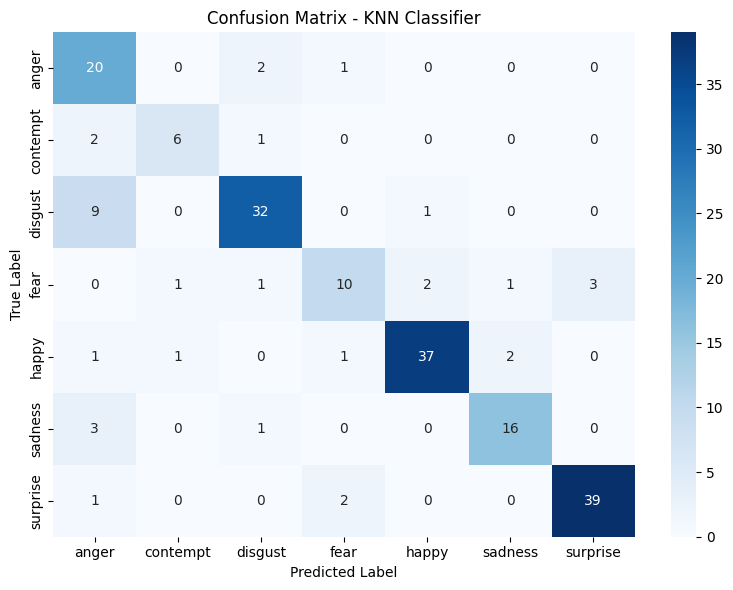

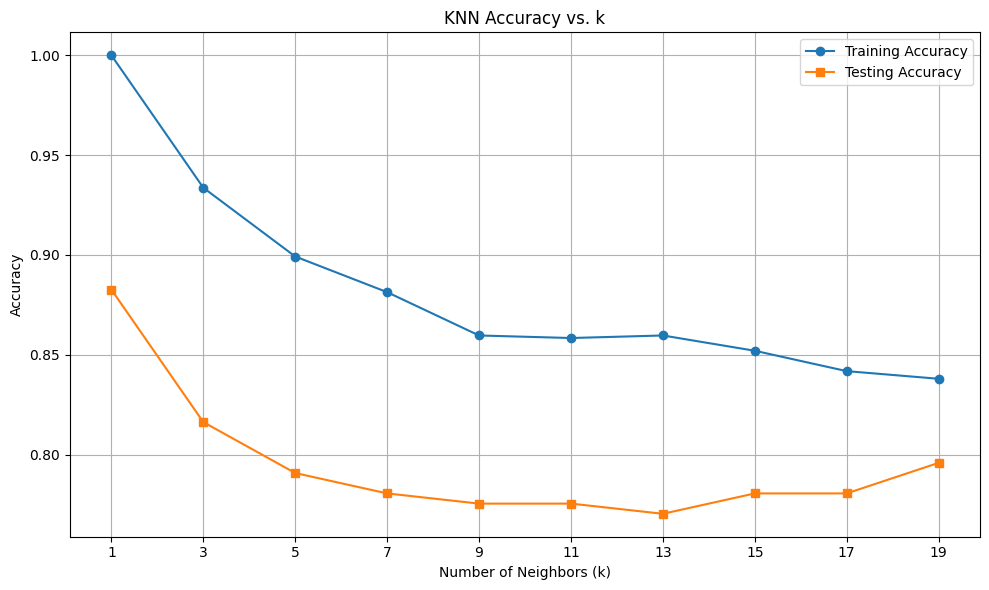

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


lda_csv_path = "processed_faces_newFinal9/lda_analysis_results/lda_features.csv"
df_lda = pd.read_csv(lda_csv_path)


feature_cols = [col for col in df_lda.columns if col.startswith("lda_feature_")]
X = df_lda[feature_cols].values                
y = df_lda["emotion"].values                   


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)


knn = KNeighborsClassifier(n_neighbors=3)  
knn.fit(X_train, y_train)


y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)


train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy:  {test_accuracy * 100:.2f}%\n")


print("Classification Report (on Test Set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - KNN Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()




import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Define a range of k values to test (odd numbers from 1 to 19)
k_values = list(range(1, 21, 2))

train_accuracies = []
test_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# 📊 Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Testing Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. k')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load LDA CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric columns like filename ---
df = df.drop(columns=['filename'])

# --- 3. Separate features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Initialize and train SVC ---
svc_model = SVC()  # Default: kernel='rbf', C=1.0, gamma='scale'
svc_model.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = svc_model.predict(X_test_scaled)

# print("✅ Training Accuracy (SVC):", round(svc_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (SVC):", round(svc_model.score(X_test_scaled, y_test), 2))

train_accuracy = svc_model.score(X_train_scaled, y_train)
test_accuracy = svc_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (SVC): {train_accuracy * 100:.2f}%")
print(f"✅ Testing Accuracy  (SVC): {test_accuracy * 100:.2f}%")
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (SVC): 88.39%
✅ Testing Accuracy  (SVC): 84.18%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.82      0.52      0.64        27
    contempt       0.75      0.82      0.78        11
     disgust       0.77      0.86      0.81        35
        fear       0.91      0.67      0.77        15
       happy       0.93      1.00      0.96        41
     sadness       0.58      0.82      0.68        17
    surprise       0.96      0.94      0.95        50

    accuracy                           0.84       196
   macro avg       0.82      0.80      0.80       196
weighted avg       0.85      0.84      0.84       196


✅ Confusion Matrix:
 [[14  0  8  0  1  3  1]
 [ 0  9  0  0  0  2  0]
 [ 1  0 30  0  1  3  0]
 [ 2  1  0 10  1  0  1]
 [ 0  0  0  0 41  0  0]
 [ 0  2  1  0  0 14  0]
 [ 0  0  0  1  0  2 47]]


✅ Training Accuracy: 86.73%
✅ Testing Accuracy:  81.63%

📊 Classification Report (on Test Data):
              precision    recall  f1-score   support

       anger       0.58      0.52      0.55        27
    contempt       0.82      0.82      0.82        11
     disgust       0.76      0.83      0.79        35
        fear       0.77      0.67      0.71        15
       happy       0.89      0.98      0.93        41
     sadness       0.77      0.59      0.67        17
    surprise       0.92      0.96      0.94        50

    accuracy                           0.82       196
   macro avg       0.79      0.77      0.77       196
weighted avg       0.81      0.82      0.81       196



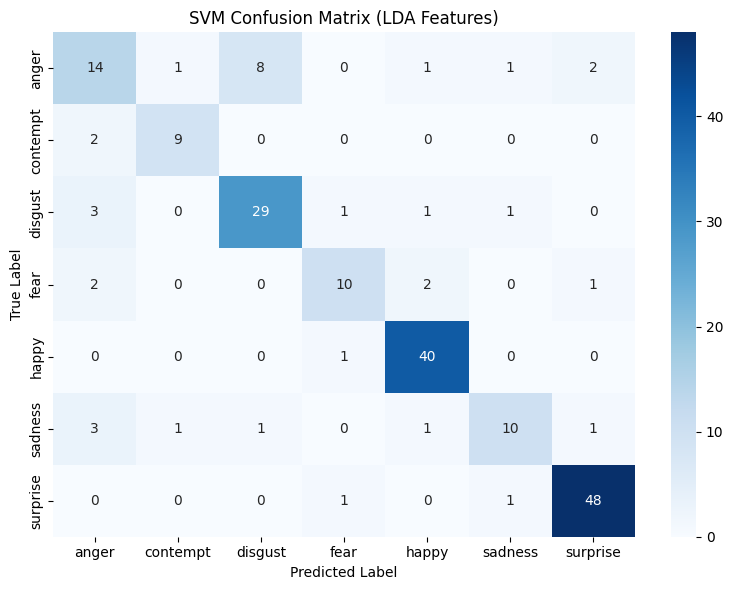

In [3]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- STEP 1: Load the LDA features CSV ---
lda_features_csv_path = "processed_faces_newFinal9/lda_analysis_results/lda_features.csv"
df = pd.read_csv(lda_features_csv_path)

# --- STEP 2: Prepare Features and Labels ---
X = df[[col for col in df.columns if col.startswith('lda_feature_')]].values
y = df['emotion'].values

# Encode string labels to integers for classification
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- STEP 3: Split the dataset into training and testing sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- STEP 4: Create and train the SVM classifier ---
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# --- STEP 5: Make predictions ---
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

# --- STEP 6: Evaluate the model ---
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"✅ Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"✅ Testing Accuracy:  {test_accuracy * 100:.2f}%")

print("\n📊 Classification Report (on Test Data):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- STEP 7: Plot confusion matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix (LDA Features)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Split features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Define parameter grid ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf']
}

# --- 8. Grid Search for best parameters ---
print("Performing Grid Search...")
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# --- 9. Train best model ---
best_svc = grid_search.best_estimator_
best_svc.fit(X_train_scaled, y_train)

# --- 10. Evaluate model ---
y_pred = best_svc.predict(X_test_scaled)

print("\n✅ Best Parameters:", grid_search.best_params_)
# print("✅ Training Accuracy (Tuned SVC):", round(best_svc.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Tuned SVC):", round(best_svc.score(X_test_scaled, y_test), 2))

train_accuracy_tuned = best_svc.score(X_train_scaled, y_train)
test_accuracy_tuned = best_svc.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Tuned SVC): {train_accuracy_tuned * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVC): {test_accuracy_tuned * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Performing Grid Search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

✅ Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
✅ Training Accuracy (Tuned SVC): 95.79%
✅ Testing Accuracy  (Tuned SVC): 82.65%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.75      0.44      0.56        27
    contempt       0.73      0.73      0.73        11
     disgust       0.74      0.89      0.81        35
        fear       0.80      0.80      0.80        15
       happy       0.95      1.00      0.98        41
     sadness       0.62      0.76      0.68        17
    surprise       0.94      0.90      0.92        50

    accuracy                           0.83       196
   macro avg       0.79      0.79      0.78       196
weighted avg       0.83      0.83      0.82       196


✅ Confusion Matrix:
 [[12  0  9  0  1  3  2]
 [ 1  8  0  0  0  2  0]
 [ 2  0 31  0  0  2  0]
 [ 1  0  0 12  1  0  1]
 [ 0  0  0  0 41  0  0]
 [ 0  2  

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Split features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Feature scaling (not mandatory for Random Forest, but added for consistency) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Initialize and train Random Forest ---
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# --- 8. Predict and evaluate ---
y_pred = rf_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Random Forest):", round(rf_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Random Forest):", round(rf_model.score(X_test_scaled, y_test), 2))

train_accuracy_rf = rf_model.score(X_train_scaled, y_train)
test_accuracy_rf = rf_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Random Forest): {train_accuracy_rf * 100:.2f}%")
print(f"✅ Testing Accuracy  (Random Forest): {test_accuracy_rf * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Random Forest): 100.00%
✅ Testing Accuracy  (Random Forest): 83.67%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.79      0.41      0.54        27
    contempt       0.92      1.00      0.96        11
     disgust       0.69      0.89      0.78        35
        fear       0.86      0.80      0.83        15
       happy       0.93      1.00      0.96        41
     sadness       0.65      0.65      0.65        17
    surprise       0.94      0.94      0.94        50

    accuracy                           0.84       196
   macro avg       0.82      0.81      0.81       196
weighted avg       0.84      0.84      0.83       196


✅ Confusion Matrix:
 [[11  0 11  0  1  3  1]
 [ 0 11  0  0  0  0  0]
 [ 1  0 31  0  1  2  0]
 [ 1  0  0 12  1  0  1]
 [ 0  0  0  0 41  0  0]
 [ 1  1  3  0  0 11  1]
 [ 0  0  0  2  0  1 47]]


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load LDA feature CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and target ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train Logistic Regression model ---
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto', random_state=42)
logreg_model.fit(X_train_scaled, y_train)

# --- 8. Evaluate the model ---
y_pred = logreg_model.predict(X_test_scaled)

# print("✅ Training Accuracy (Logistic Regression):", round(logreg_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (Logistic Regression):", round(logreg_model.score(X_test_scaled, y_test), 2))

train_accuracy_logreg = logreg_model.score(X_train_scaled, y_train)
test_accuracy_logreg = logreg_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (Logistic Regression): {train_accuracy_logreg * 100:.2f}%")
print(f"✅ Testing Accuracy  (Logistic Regression): {test_accuracy_logreg * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (Logistic Regression): 83.80%
✅ Testing Accuracy  (Logistic Regression): 82.65%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.72      0.48      0.58        27
    contempt       0.75      0.82      0.78        11
     disgust       0.72      0.74      0.73        35
        fear       0.86      0.80      0.83        15
       happy       0.91      1.00      0.95        41
     sadness       0.68      0.76      0.72        17
    surprise       0.92      0.96      0.94        50

    accuracy                           0.83       196
   macro avg       0.80      0.80      0.79       196
weighted avg       0.82      0.83      0.82       196


✅ Confusion Matrix:
 [[13  1  8  0  1  2  2]
 [ 0  9  0  0  0  2  0]
 [ 4  0 26  1  2  1  1]
 [ 1  1  0 12  1  0  0]
 [ 0  0  0  0 41  0  0]
 [ 0  1  2  0  0 13  1]
 [ 0  0  0  1  0  1 48]]


c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- 1. Load the LDA feature CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric 'filename' column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# --- 6. Normalize the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Train the MLP Classifier ---
mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# --- 8. Evaluate the model ---
y_pred = mlp_model.predict(X_test_scaled)

# print("✅ Training Accuracy (MLP):", round(mlp_model.score(X_train_scaled, y_train), 2))
# print("✅ Testing Accuracy (MLP):", round(mlp_model.score(X_test_scaled, y_test), 2))


train_accuracy_mlp = mlp_model.score(X_train_scaled, y_train)
test_accuracy_mlp = mlp_model.score(X_test_scaled, y_test)

print(f"✅ Training Accuracy (MLP): {train_accuracy_mlp * 100:.2f}%")
print(f"✅ Testing Accuracy  (MLP): {test_accuracy_mlp * 100:.2f}%")

print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Training Accuracy (MLP): 96.56%
✅ Testing Accuracy  (MLP): 83.67%

✅ Classification Report:
               precision    recall  f1-score   support

       anger       0.83      0.56      0.67        27
    contempt       0.64      0.82      0.72        11
     disgust       0.82      0.80      0.81        35
        fear       0.85      0.73      0.79        15
       happy       0.93      1.00      0.96        41
     sadness       0.55      0.71      0.62        17
    surprise       0.94      0.96      0.95        50

    accuracy                           0.84       196
   macro avg       0.79      0.80      0.79       196
weighted avg       0.85      0.84      0.83       196


✅ Confusion Matrix:
 [[15  0  6  0  1  4  1]
 [ 1  9  0  0  0  1  0]
 [ 1  0 28  1  1  4  0]
 [ 1  1  0 11  1  0  1]
 [ 0  0  0  0 41  0  0]
 [ 0  4  0  0  0 12  1]
 [ 0  0  0  1  0  1 48]]


c:\Users\sahug\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoch 1/50
25/25 [==============================] - 1s 5ms/step - loss: 1.7492 - accuracy: 0.3852 - val_loss: 1.5698 - val_accuracy: 0.6020
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.3931 - accuracy: 0.7092 - val_loss: 1.2717 - val_accuracy: 0.7398
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1138 - accuracy: 0.7742 - val_loss: 1.0523 - val_accuracy: 0.7704
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.9114 - accuracy: 0.8036 - val_loss: 0.8981 - val_accuracy: 0.7704
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.7722 - accuracy: 0.8151 - val_loss: 0.7952 - val_accuracy: 0.7755
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.8125 - val_loss: 0.7269 - val_accuracy: 0.7704
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6161 - accuracy: 0.8202 - val_loss: 0.6790 - val_accuracy: 0.7755
Epoch 8/50
25/25 [==

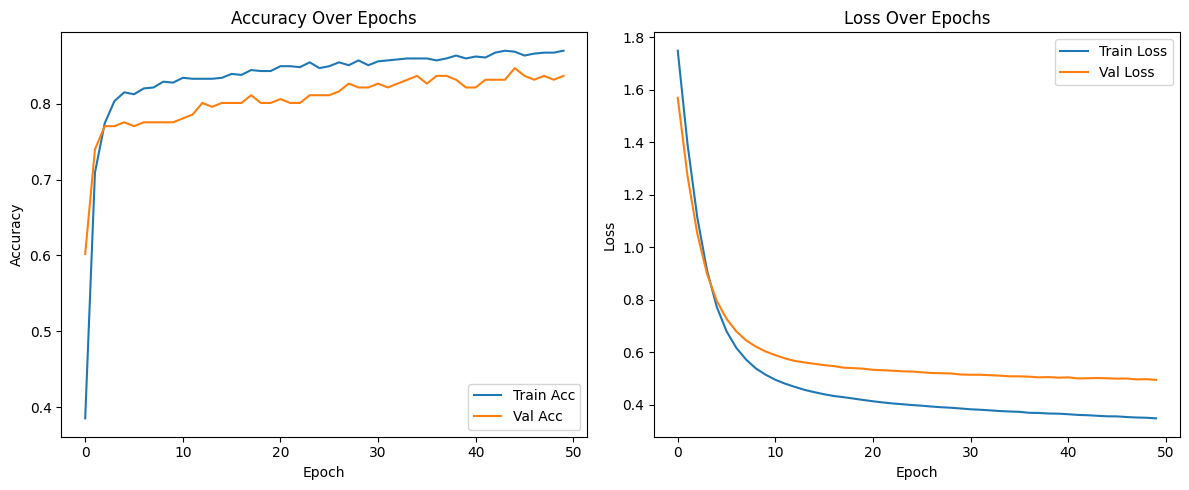

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# --- 1. Load the LDA feature CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric 'filename' column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Normalize the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Build and compile Keras MLP model ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Train the model and capture training history ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# --- 9. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Keras MLP): {test_acc * 100:.2f}%")


# --- 9. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Keras MLP): {test_acc * 100:.2f}%")

# --- 📌 Added: Classification Report & Confusion Matrix ---
from sklearn.metrics import classification_report, confusion_matrix

# Convert one-hot labels back to class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(X_test_scaled), axis=1)

# Classification Report
print("\n✅ Classification Report:\n", classification_report(
    y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))


# --- 10. Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/150
25/25 [==============================] - 0s 8ms/step - loss: 1.6803 - accuracy: 0.4758 - val_loss: 1.3978 - val_accuracy: 0.6684
Epoch 2/150
25/25 [==============================] - 0s 2ms/step - loss: 1.1925 - accuracy: 0.7270 - val_loss: 1.0120 - val_accuracy: 0.7449
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8627 - accuracy: 0.7870 - val_loss: 0.7878 - val_accuracy: 0.7806
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.7997 - val_loss: 0.6820 - val_accuracy: 0.7704
Epoch 5/150
25/25 [==============================] - 0s 4ms/step - loss: 0.5980 - accuracy: 0.8048 - val_loss: 0.6295 - val_accuracy: 0.8010
Epoch 6/150
25/25 [==============================] - 0s 3ms/step - loss: 0.5454 - accuracy: 0.8087 - val_loss: 0.5919 - val_accuracy: 0.7857
Epoch 7/150
25/25 [==============================] - 0s 3ms/step - loss: 0.5122 - accuracy: 0.8202 - val_loss: 0.5772 - val_accuracy: 0.7959
Epoch 8/150
2

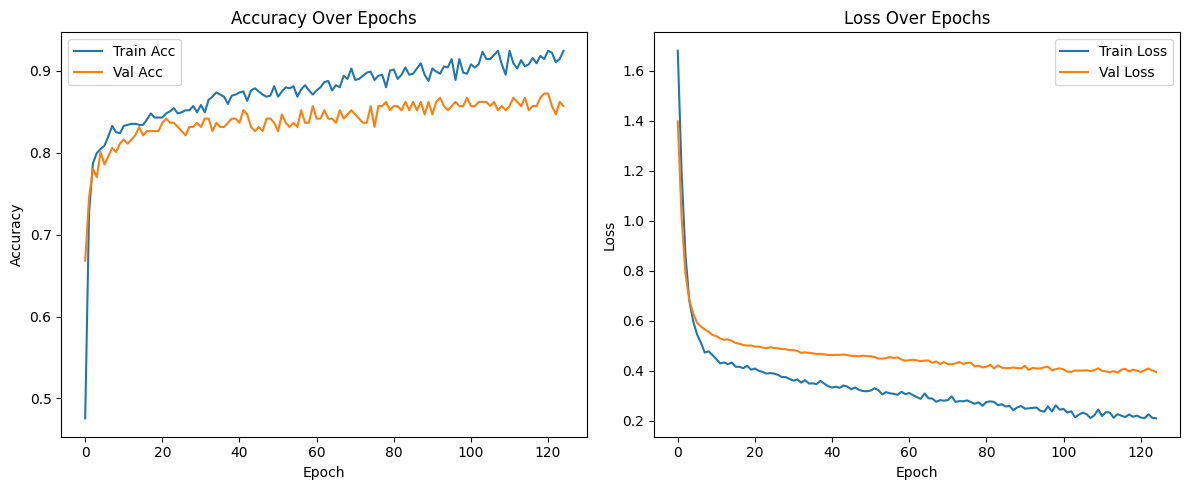

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Load CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop filename column ---
df = df.drop(columns=['filename'])

# --- 3. Features & Labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Scale Features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Build Improved MLP Model ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),  # Reduces overfitting
    Dense(50, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Early Stopping Setup ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# --- 9. Train Model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 10. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Improved Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Improved Keras MLP): {test_acc * 100:.2f}%")

# --- 11. Plot Accuracy & Loss ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/150
25/25 [==============================] - 0s 6ms/step - loss: 1.7001 - accuracy: 0.4503 - val_loss: 1.4455 - val_accuracy: 0.6020
Epoch 2/150
25/25 [==============================] - 0s 2ms/step - loss: 1.2081 - accuracy: 0.6926 - val_loss: 1.0154 - val_accuracy: 0.7602
Epoch 3/150
25/25 [==============================] - 0s 2ms/step - loss: 0.8646 - accuracy: 0.7653 - val_loss: 0.7592 - val_accuracy: 0.7908
Epoch 4/150
25/25 [==============================] - 0s 3ms/step - loss: 0.6547 - accuracy: 0.8061 - val_loss: 0.6370 - val_accuracy: 0.7857
Epoch 5/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.8176 - val_loss: 0.5855 - val_accuracy: 0.7857
Epoch 6/150
25/25 [==============================] - 0s 2ms/step - loss: 0.5016 - accuracy: 0.8240 - val_loss: 0.5623 - val_accuracy: 0.7908
Epoch 7/150
25/25 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.8316 - val_loss: 0.5460 - val_accuracy: 0.8112
Epoch 8/150
2

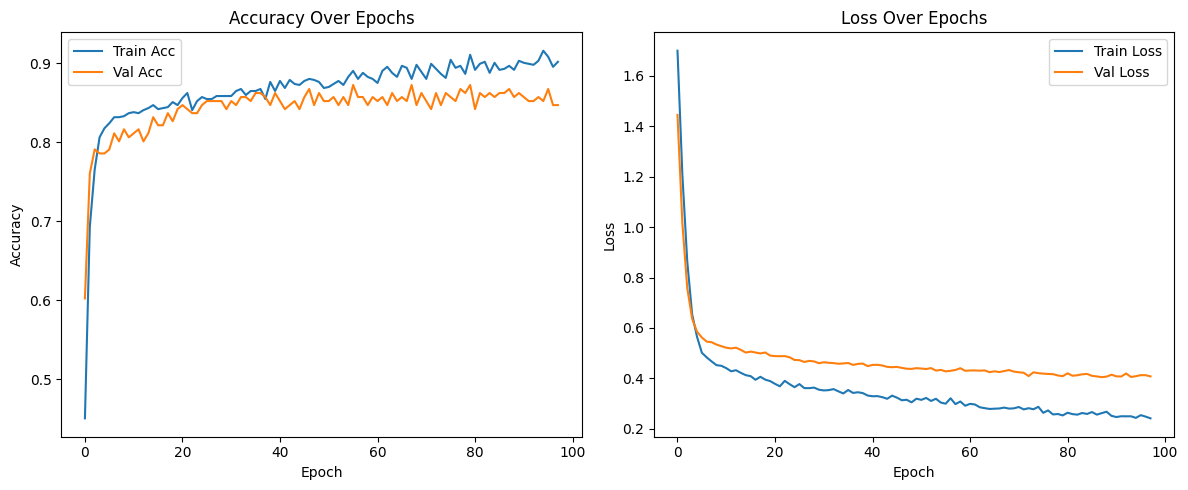

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Load the LDA feature CSV ---
file_path = 'processed_faces_newFinal9/lda_analysis_results/lda_features.csv'
df = pd.read_csv(file_path)

# --- 2. Drop non-numeric 'filename' column ---
df = df.drop(columns=['filename'])

# --- 3. Define features and labels ---
X = df.drop(columns=['emotion'])
y = df['emotion']

# --- 4. Encode emotion labels ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# --- 5. Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# --- 6. Normalize the features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 7. Build and compile Keras MLP model ---
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- 8. Early Stopping Setup ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# --- 9. Train the model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# --- 10. Final Evaluation ---
train_loss, train_acc = model.evaluate(X_train_scaled, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"\n✅ Final Training Accuracy (Improved Keras MLP): {train_acc * 100:.2f}%")
print(f"✅ Final Testing Accuracy  (Improved Keras MLP): {test_acc * 100:.2f}%")

# --- 11. Classification Report & Confusion Matrix ---
# Predict class indices
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(model.predict(X_test_scaled), axis=1)

# Classification Report
print("\n✅ Classification Report:\n", classification_report(
    y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Confusion Matrix
print("\n✅ Confusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

# --- 12. Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
